# Práctica de reconstrucción.  Parte II. Visión estéreo

Visión Computacion <br>
Practica 2.

Este enunciado está en el archivo "PracticaStereo.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* reconstruir puntos de una escena a partir de una serie de correspondencias manuales entre dos imágenes calibradas;
* determinar la geometría epipolar de un par de cámaras a partir de sus matrices de proyección;
* implementar la búsqueda automática de correspondencias que use las restricciones impuestas por la geometría epipolar, aplicando para ello métodos de cortes de grafos;
* realizar una reconstrucción densa de la escena.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV
* La librería PyMaxFlow

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica`` del tema de visión estéreo. Esta
carpeta contiene:
* Una serie de pares estéreo en el directorio images;
el sufijo del fichero indica si corresponde a la cámara
izquierda (_left) o a la derecha (_right). Bajo el
directorio ``rectif`` se encuentran varios pares estéreo
rectificados.
* Un conjunto de funciones auxiliares de ``Python`` en 
el módulo ``misc.py``. La descripción de las funciones
puede consultarse con el comando help o leyendo
su código fuente.
* El archivo ``cameras.npz`` con las matrices de proyección del par de cámaras con el que se tomaron todas las imágenes con prefijo minoru.

## Condiciones

* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Introducción

En los problemas de visión estéreo se supondrá la existencia de un par de cámaras calibradas cuyas matrices de proyección $\mathbf{P}_i$ vienen dadas
por $$\mathbf{P}_1 = \mathbf{K}_1\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_1 & \mathbf{t}_1\\ \mathbf{0}^T & 1
    \end{bmatrix},$$ $$\mathbf{P}_2 = \mathbf{K}_2\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_2 & \mathbf{t}_2\\ \mathbf{0}^T & 1
    \end{bmatrix}.$$
    
En esta práctica se usarán las matrices de proyección de
dos cámaras para determinar la posición tridimensional
de puntos de una escena. Esto es posible siempre que se
conozcan las proyecciones de cada punto en ambas cámaras. Desafortunadamente, esta información no suele estar
disponible y para obtenerla es preciso emplear el contenido
de las imágenes (sus píxeles) en un proceso de búsqueda
conocido como puesta en correspondencia. Conocer las matrices de proyección de las cámaras permite acotar el área
de búsqueda gracias a las restricciones que proporciona la
geometría epipolar.

In [157]:
# uncomment to show results in a window
%matplotlib tk
import numpy as np
import scipy.misc as scpm
import scipy.ndimage as scnd
import matplotlib.pyplot as ppl
import numpy.linalg as npla
import maxflow.fastmin
import matplotlib.pyplot as plt
import misc

## 1. Reconstrucción

Teniendo un conjunto de correspondencias entre dos
imágenes, con matrices de calibración $P_i$ conocidas, es
posible llevar a cabo una reconstrucción tridimensional de
dichos puntos. En el fichero ``cameras.npz`` se encuentran
las matrices de proyección para las dos cámaras. Para cargar
este fichero:

In [2]:
cameras = np.load("cameras.npz")
P1 = cameras["left"]
P2 = cameras["right"]

In [3]:
P1, P2

(array([[-1.59319023e+02,  4.10068927e+02, -8.61429776e+01,
          5.96021124e+04],
        [ 9.56736123e+01, -6.85256589e+00, -4.31511155e+02,
          2.98592912e+04],
        [-8.69896273e-01, -7.51069223e-02, -4.87482742e-01,
          5.44164509e+02]]),
 array([[-1.49296958e+02,  4.20482251e+02, -8.03699899e+01,
          2.66669558e+04],
        [ 9.61686671e+01, -2.92284678e+00, -4.41950717e+02,
          3.12991880e+04],
        [-8.64354364e-01, -5.83462724e-02, -4.99486983e-01,
          5.42414607e+02]]))

Todas las imágenes con el prefijo minoru comparten este par de matrices de proyección.

Leemos las imágenes y marcammos al menos seis puntos correspondientes en cada una de ella.

In [4]:
# img1 = scpm.imread("images/minoru_cube3_left.jpg")
# img2 = scpm.imread("images/minoru_cube3_right.jpg")
img1 = plt.imread("images/minoru_cube3_left.jpg")
img2 = plt.imread("images/minoru_cube3_right.jpg")

In [5]:
pt1, pt2 = misc.askpoints(img1,img2)

TclError: can't invoke "update" command: application has been destroyed

In [6]:
pt1, pt2

NameError: name 'pt1' is not defined

In [8]:
pt1 = np.array([[108.06090304, 209.14057998, 305.56527181, 290.27032069,
         204.48559486, 116.04087753],
        [ 25.33962594,  57.25952392,  28.66461531, 152.35422   ,
         204.22405422, 147.69923487],
        [  1.        ,   1.        ,   1.        ,   1.        ,
           1.        ,   1.        ]])
pt2 = np.array([[  7.34999764,  79.1697681 , 205.51936428, 202.19437491,
          99.11970434,  24.63994238],
        [ 30.65960894,  61.91450904,  30.65960894, 159.66919662,
         208.87903934, 153.68421575],
        [  1.        ,   1.        ,   1.        ,   1.        ,
           1.        ,   1.        ]])

**Ejercicio 1.** Implementa la función ``M = reconstruct(points1, points2, P1, P2)``
que, dados una serie de N puntos 2D ``points1`` de la primera imagen y sus 
N homólogos ``points2`` de la segunda imagen
(ambos en coordenadas homogéneas, 3 x N), y el par de matrices
de proyección P1 y P2 de la primera y la segunda cámara
respectivamente, calcule la reconstrucción tridimensional
de cada punto. De ese modo, si ``points1`` y
``points2`` son 3 × N , la matriz resultante M debe ser 4 × N.

El tipo de reconstrucción debe ser algebraico, no geométrico.


In [10]:
def to_cartesian(points_hom):
    return points_hom[0:-1,:]/points_hom[-1]

def reconstruct(points1, points2, P1, P2):

    """Reconstruct a set of points projected on two images."""
    
    # Transform homog to cartesian co-ordinates
    points1_car = to_cartesian(points1).transpose()
    points2_car = to_cartesian(points2).transpose()

    # build coefficient matrix and compute reconstruction by least-squares.    
    
    def reconstruct_(point1,point2,P1,P2):
    
        coeffs = np.array([
                P1[0]-P1[2]*point1[0],
                P1[1]-P1[2]*point1[1],
                P2[0]-P2[2]*point2[0],
                P2[1]-P2[2]*point2[1],
            ])

        A = coeffs[:,:-1]
        b = - coeffs[:,-1]
                
        sol,_,_,_ = npla.lstsq(A,b)
        
        return np.append(sol,1)
        
    return np.array([reconstruct_(p1,p2,P1,P2) for p1,p2 in zip(points1_car,points2_car)]).T

Reconstruye los puntos marcados y pinta su estructura 3D.

In [11]:
# reconstruct
mM=reconstruct(pt1, pt2, P1, P2)

# convert from homog to cartesian
mM_c = to_cartesian(mM)

# plot 3D
%matplotlib tk
misc.plot3D(mM_c[0,:],mM_c[1,:],mM_c[2,:])

/home/alberto/anaconda3/envs/vc/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


**Ejercicio 2.**  Reproyecta los resultados de la reconstrucción
en las dos cámaras y dibuja las proyecciones sobre las
imágenes originales. Pinta también en otro color los puntos seleccionados manualmente. Comprueba si las proyecciones coinciden con los puntos marcados a mano. Comenta los resultados.
Para dibujar los puntos puedes usar la función plothom
de la práctica anterior o la versión que se distribuye con esta
práctica (misc.plothom).

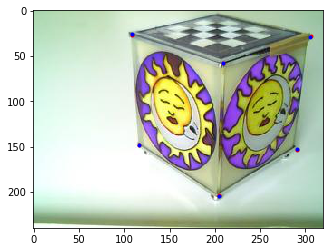

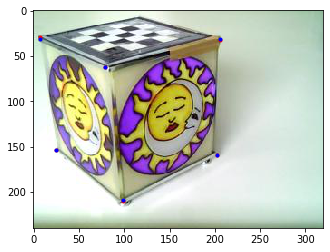

In [12]:
# Proyecto los puntos en ambas cámaras
proy1 = P1.dot(mM)
proy2 = P2.dot(mM)

%matplotlib inline

# Pinto con misc.plothom()
ppl.figure()
misc.plothom(proy1,'r.')
misc.plothom(pt1,'b.')
ppl.imshow(img1)
ppl.show()

ppl.figure()
misc.plothom(proy2,'r.')
misc.plothom(pt2,'b.')
ppl.imshow(img2)
ppl.show()

## 2. Geometría epipolar

La geometría epipolar deriva de las relaciones que aparecen en las proyecciones de una escena sobre un par de
cámaras. La matriz fundamental $\mathbf{F}$, que depende exclusivamente de la configuración de las cámaras y no de la escena
que éstas observan, es la representación algebráica de dicha
geometría: a partir de ella se pueden calcular los epipolos
y las líneas epipolares. La relación entre un par de cámaras
$\mathbf{P}_1$, $\mathbf{P}_2$ y la matriz fundamental es de n -a- 1 (salvo factor de
escala). Es decir, dadas dos cámaras calibradas, sólo tienen
una matriz fundamental (excepto un factor de escala); dada
una matriz fundamental existen infinitas configuraciones de
cámaras posibles asociadas a ella.

### 2.1 Estimación de la matriz fundamental

**Ejercicio 3.** Implementa la función ``F = projmat2f(P1, P2)``
que, dadas dos matrices de proyección, calcule la matriz
fundamental asociada a las mismas. $\mathbf{F}$ debe ser tal que,
si $m_1$ de la imagen 1 y $m_2$ de la imagen 2 están en
correspondencia, entonces $m_2^\top F m_1 = 0$.

In [172]:
def projmat2f(P1,P2):
    """ Calcula la matriz fundamental a partir de dos de proyeccion"""
    
    invA1= npla.inv(P1[:,0:3])
    b1 = P1[:,3]
    
    invA2= npla.inv(P2[:,0:3])
    b2 = P2[:,3]

    w = invA2.dot(b2) - invA1.dot(b1)
    Q = misc.skew(w)
    
    return invA2.transpose().dot(Q).dot(invA1)

In [173]:
# compute Fundamental matrix
F = projmat2f(P1, P2)
F

array([[ 8.37918051e-09, -2.64352488e-06,  8.61307712e-04],
       [ 8.17120601e-06,  4.36740640e-06,  1.37641120e-01],
       [-2.27541839e-03, -1.42176580e-01,  7.61491838e-03]])

**Ejercicio 4** ¿Cómo es la matriz fundamental de dos cámaras
que comparten el mismo centro? (Por ejemplo, dos cámaras
que se diferencian sólo por una rotación.)

### 2.2 Comprobación de F (OPCIONAL)

En los siguientes dos ejercicios vamos a comprobar que la matriz F estimada a partir de P1 y P2 es correcta.

**Ejercicio 5.** Comprueba que F es la matriz fundamental asociada a las cámaras ``P1`` y ``P2``. Para ello puedes utilizar el resultado 9.12, que aparece en la página 255 del libro Hartley, Zisserman. "Multipe View Geometry in Computer Vision." (sedond edition). Cambridge University Press, 2003.

In [ ]:
M = P2.transpose().dot(F).dot(P1)
M + M.T

Para comprobarlo M debe ser una matriz antisimetrica, por lo que al sumarse con sigo misma debería dar una matriz con valores cercanos a 0.

También se puede comprobar geométricamente la bondad de una matriz F, si  las epipolares con ella estimadas pasan por el homólogo de un punto dado en una de las imágenes.

Dada la matriz fundamental $\mathbf{F}$ entre las cámaras 1 y 2,
se puede determinar, para un determinado punto $m_1$ en la
imagen de la cámara 1, cuál es la recta epipolar $l_2$ donde se
encontrará su homólogo en la cámara 2: $$l_2 = \mathbf{F} m_1.$$

Las siguientes dos funciones sirven para comprobar esta
propiedad. En primer lugar, se necesita una función que
dibuje rectas expresadas en coordenadas homogéneas, es
decir, la versión de plothom para rectas en lugar de puntos.

**Ejercicio 6.** Implementa la función ``plothline(line)``
que, dada una línea expresada en coordenadas homogéneas,
la dibuje.

In [167]:
def plothline(line, axes = None):
    """Plot a line given its homogeneous coordinates.
    
    Parameters
    ----------
    line : array_like
        Homogeneous coordinates of the line.
    axes : AxesSubplot
        Axes where the line should be plotted. If not given,
        line will be plotted in the active axis.
    """
    if axes == None:
        axes = ppl.gca()
    
    [x0, x1, y0, y1] = axes.axis()

    #     (x0, y0) ._____________________. (x1, y0)
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #     (x0, y1) .---------------------. (x1, y1)
 
    # TODO: Compute the intersection of the line with the image
    # borders.
    a,b,c = line[0], line[1], line[2] 
    
    ay = (x0 * a + c) / -b
    by = (x1 * a + c) / -b
    
       
    # TODO: Plot the line with axes.plot.
    #axes.plot(...)
    plotline = axes.plot([x0, x1], [ay, by], 'r-')
    
    axes.axis([x0, x1, y0, y1])
    return plotline

**Ejercicio 7.** Completa la función ``plot_epipolar_lines(image1, image2, F)``
que, dadas dos imágenes y la matriz fundamental que
las relaciona, pide al usuario puntos en la imagen 1 y
dibuje sus correspondientes epipolares en la imagen 2 usando ``plothline``.

In [160]:
def plot_epipolar_lines(image1, image2, F):
    """Ask for points in one image and draw the epipolar lines for those points.
    
    Parameters
    ----------
    image1 : array_like
        First image.
    image2 : array_like
        Second image.
    F : array_like
        3x3 fundamental matrix from image1 to image2.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.hstack([np.array(point[0]), 1])
        ax1.plot(point[0], point[1], '.r')
        
        # TODO: Determine the epipolar line.
        line = F.dot(point)
        
        # Plot the epipolar line with plothline (the parameter 'axes' should be ax2).
        plothline(line, axes=ax2)
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

Utiliza esta función con un par de imágenes llamándola
de dos formas diferentes: seleccionando puntos en la imagen
izquierda y dibujando las epipolares en la imagen derecha
y viceversa. Comprueba en ambos casos que las epipolares
siempre pasan por el punto de la segunda imagen correspondiente al seleccionado en la primera. Esto confirmara la corrección de la matriz F.

Añade dos figuras una que muestre la selección de puntos en
la imagen izquierda y las rectas correspondientes en la
imagen derecha, y otra que lo haga al revés. Indica para
ambos casos qué matriz fundamental has usado al llamar a
``plot_epipolar_lines``.

In [176]:
plot_epipolar_lines(img1, img2, F)

TclError: can't invoke "update" command: application has been destroyed

In [171]:
plot_epipolar_lines(img2, img1, F.T)

TclError: can't invoke "update" command: application has been destroyed

##  3. Rectificación de imágenes

Es recomendable trabajar a partir de ahora con imágenes
en blanco y negro y con valores reales entre 0 y 1 para cada
uno de sus píxeles. Eso se puede conseguir con

In [17]:
img1 = misc.rgb2gray(img1/255.0)
img2 = misc.rgb2gray(img2/255.0)

La mayoría de algoritmos de puesta en correspondencia,
incluyendo el que se va a implementar en esta práctica,
requieren que las imágenes de entrada estén rectificadas.

Dos imágenes están rectificadas si sus correspondientes epipolares están alineadas horizontalmente. La rectificación de
imágenes facilita enormemente los algoritmos de puesta en
correspondencia, que pasan de ser problemas de búsqueda
bidimensional a problemas de búsqueda unidimensional
sobre filas de píxeles de las imágenes. En el material de
la práctica se han incluido dos funciones que rectifican
(mediante un método lineal) dos imágenes. La función
``H1, H2 = misc.projmat2rectify(P1, P2, imsize)``
devuelve, dadas las dos matrices de proyección y el tamaño de las imágenes en formato (filas,columnas), las
homografías que rectifican, respectivamente, la imagen 1
y la imagen 2. La función ``projmat2rectify`` hace uso
de ``projmat2f``, por lo que
es necesario que esta función esté disponible.

**Ejercicio 8.** Se tienen dos imágenes no rectificadas ``im1`` e
``im2``, y su matriz fundamental asociada $\mathbf{F}$ . Con el procedimiento explicado, se encuentran un par de homografías $\mathbf{H}_1$ y $\mathbf{H}_2$ que dan lugar a las imágenes rectificadas ``O1`` y ``O2``. ¿Cuál es la matriz fundamental $\mathbf{F}′$ asociada a estas dos imágenes? ¿Por qué?

Nota: F ′ depende exclusivamente de F , H1 y H2.

La matriz fundamental $\mathbf{F}′$ se obtendría a partir de $\mathbf{F}′ = (\mathbf{H}_2^{-1})^{T} \mathbf{F} \mathbf{H_1^{-1}}$

Dados dos puntos cualesquiera en correspondencia sobre ambas imagenes rectificadas ``O1`` y ``O2``, $\mathbf{m}_1'$  y $\mathbf{m}_2'$. Entonces tenemos que $\mathbf{m}_2'^{T} \mathbf{F}' \mathbf{m}_1' = 0$. Los puntos que se encuentran en las imágenes no rectificadas se obtendrían a partir de $\mathbf{m}_1 = \mathbf{m}_1' \mathbf{H_1^{-1}}$ y $\mathbf{m}_2 = \mathbf{m}_2' \mathbf{H_2^{-1}}$. Sabemos que $\mathbf{m}_2^{T} \mathbf{F} \mathbf{m}_1 = 0$, si igualamos amabas fórmulas obtendremos $\mathbf{m}_2'^{T} \mathbf{F}' \mathbf{m}_1' = \mathbf{m}_2^{T} \mathbf{F} \mathbf{m}_1 = (\mathbf{m}_2' \mathbf{H_2^{-1}})^{T} \mathbf{F}\mathbf{m}_1' \mathbf{H_1^{-1}}$, y simplemente despejando se obtendrá la fórmula inicialmente enunciada.

**Ejercicio 9.** Rectifica el par de imágenes estéreo ``img1`` e ``img2`` y calcula
la matriz fundamental asociada a estas imágenes.

In [18]:
from numpy.linalg import inv

H1, H2 = misc.projmat2rectify(P1, P2, projmat2f, img1.shape)
O1, O2 = misc.rectify_images(img1, img2, H1, H2)
F_prima = np.transpose(inv(H2)).dot(F).dot(inv(H1))
print(F_prima)

[[-4.21233401e-24 -1.61290225e-18  1.09519766e-15]
 [ 1.28911943e-18  3.82441816e-19  5.22829530e-02]
 [-1.29153184e-15 -5.22829530e-02  1.07463351e-13]]


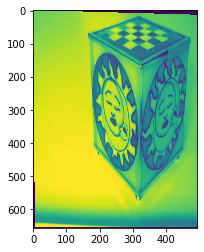

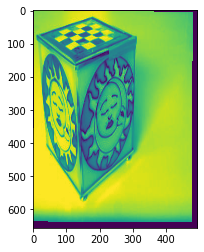

In [19]:
ppl.imshow(O1)
ppl.figure()
ppl.imshow(O2)

**Ejercicio 10. (opcional)** Calcula y muestra la matriz fundamental de las imágenes
rectificadas. Justifica el resultado obtenido (mira la sección 9.3.1 del libro de Hartley y Zisserman, pág. 248 y 249).

In [20]:
Fr=F_prima
Fr=Fr/Fr[2,1]
Fr

array([[ 8.05680202e-23,  3.08494863e-17, -2.09475095e-14],
       [-2.46565918e-17, -7.31484726e-18, -1.00000000e+00],
       [ 2.47027332e-14,  1.00000000e+00, -2.05541853e-12]])

**Ejercicio 11. (Opcional)** Usa ``plot_epipolar_lines`` para dibujar varias líneas epiplares de las imágenes rectificadas. Muestra los resultados.

In [21]:
plot_epipolar_lines(O1,O2,Fr)

NameError: name 'plot_epipolar_lines' is not defined

## 4. Búsqueda de correspondencias

La búsqueda de correspondencias consigue establecer automáticamente las correspondencias de puntos entre dos
imágenes (lo que se ha hecho manualmente en el ejercicio 2)
haciendo uso de las restricciones que proporciona la geometría epipolar.

### 4.1 Cálculo de las medidas de similaridad

Una vez rectificadas las dos imágenes de un par estéreo,
se pueden buscar las correspondencias. Una matriz de disparidades $\mathbf{S}$ indica, para cada píxel de la imagen 1
rectificada, a cuántos píxeles de diferencia está su correspondencia
en la imagen 2 rectificada. En nuestra práctica, para simplificar el problema, vamos a considerar que los elementos
de $\mathbf{S}$ son enteros. Para el píxel en la posición $(x, y)$ en la
imagen 1, su correspondiente está en $(x + S[y, x], y)$ en la
imagen 2. Si $S[y, x] < 0$, la correspondencia está hacia la
izquierda; si $S[y, x] > 0$, la correspondencia está hacia la
derecha; si $S[y, x] = 0$, las coordenadas de los dos puntos
coinciden en ambas imágenes.

La búsqueda de correspondencias requiere ser capaz de
determinar el parecido visual entre píxeles de dos imágenes.
Si los píxeles $m_1$ y $m_2$ son visualmente parecidos, tienen
más probabilidad de estar en correspondencia que otros
que sean visualmente diferentes. Como la
apariencia (el nivel de gris) de un único píxel es propensa
al ruido y poco discriminativa, el elemento de puesta en
correspondencia será una ventana centrada en el píxel.
Dado un píxel $m$ de una imagen, llamaremos vecindad
del píxel de radio $K$ al conjunto de píxeles de la imagen que se encuentren dentro de una ventana de tamaño
$(2K + 1) × (2K + 1)$ píxeles centrada en $m$ . El número de
píxeles de una vecindad de radio $K$ es $N = (2K + 1)^2$.
Dadas dos vecindades $w_1$ y $w_2$ de dos píxeles, el parecido
visual entre ellas puede calcularse con la suma de *diferencias
al cuadrado (SSD)* de cada una de sus componentes
$$d_{SSD}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^N(\mathbf{v}_i - \mathbf{w}_i)^2.$$

La distancia $d_{SSD}$ es siempre positiva, es pequeña cuando
dos ventanas son visualmente parecidas y grande en caso
contrario.

**Ejercicio 12.** Implementa la función
``C = localssd(im1, im2, K)``
que calcula la suma de diferencias al cuadrado entre las
ventanas de radio K de la imagen 1 y la imagen 2. El
resultado debe ser una matriz del mismo tamaño que las
imágenes de entrada que contenga en cada punto el valor
de $d_{SSD}$ para la ventana de la imagen 1 y la ventana
de la imagen 2 centradas en él. Es decir, $C[i,j]$ debe
ser el resultado de $d_{SSD}$ para las ventanas centradas en
$im1[i,j]$ e $im2[i,j]$.

Para este ejercicio puede resultar útil la función
``scipy.ndimage.convolve``.

In [22]:
from scipy.ndimage import convolve
def localssd(im1, im2, K):
    """
    The local sum of squared differences between windows of two images.
    
    The size of each window is (2K+1)x(2K+1).
    """
    window = K * 2 + 1
    
    squared_dif = (im1 - im2) ** 2
    weights = np.ones((window, window))
    
    return convolve(squared_dif, weights, mode='constant', cval=0.0)

localssd(O1, O2, 5).shape

(656, 495)

**Ejercicio 13.** Implementa la función ``D = ssd_volume(im1, im2, disps, K)`` que calcula la suma de diferencias al cuadrado entre las
ventanas de la imagen ``im1`` y la imagen ``im2`` desplazada
horizontalmente. El parámetro ``disps`` debe ser una lista
de valores indicando las disparidades que se usarán para desplazar la imagen ``im2``. Por ejemplo, si ``disps`` es
``np.arange(-3,2)``, se llamará 5 veces a ``localssd`` para la
imagen 1 y la imagen 2 desplazada −3 , −2 , −1 , 0 y 1 píxeles
en sentido horizontal. K es el parámetro que indica el radio
de las ventanas usado por localssd.

El valor devuelto D será un array de tamaño $M × N × L$,
donde L es el número de disparidades indicadas por ``disps``,
``L = len(disps)`` (es decir, el número de veces que se ha
llamado a ``localssd``); M y N son, respectivamente, el
número de filas y de columnas de las imágenes de entrada.
El elemento ``D[y,x,l]`` debe ser la SSD entre la ventana
centrada en ``im1[y,x]`` y la ventana centrada en ``im2[y,x + disps[l]]``.

``D[y,x,l]`` debe ser muy grande para aquellos valores en
los que ``im2[y,x + disps[l]]`` no esté definido, es decir,
el índice``(y,x+disps[l])`` se sale de la imagen 2.

(656, 495)

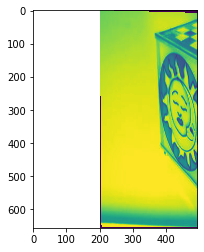

In [149]:
def shift(im, d):
    
    h, w = im.shape
    desp = np.ones((h, abs(d))) * np.inf
    
    if d >= 0:
        return np.hstack((im[:, d:], desp))
    else:
        return np.hstack((desp, im[:, :d]))

def ssd_volume(im1, im2, disps, K):
    """
    Calcula el volumen de disparidades SSD
    """
    D = np.empty((im1.shape[0], im1.shape[1], len(disps)))
    
    for index, d in enumerate(disps):
        D[:,:,index] = localssd(im1, shift(im2, d), K)
    return D
            
plt.imshow(shift(O1,-200))
shift(O1,50).shape

**Ejercicio 14.** El conjunto de disparidades ``disps`` debe ser lo más pequeño posible, para mejorar el rendimiento de la optimización. Determina un procedimiento para estimar manualmente el conjunto de disparidades posibles y aplícalo a las imágenes O1 y O2.

Buscamos de manera manual los puntos con mayor disparidad en las rectificaciones, los más cercanos a las cámaras. Se descarta la disparidad del fondo

In [144]:
import matplotlib.pyplot as plt
%matplotlib tk
plt.imshow(O1)
pt1, pt2 = misc.askpoints(O1,O2)
%matplotlib inline
p = pt1 - pt2

In [145]:
disps = np.arange( 130, 200)

In [150]:
disps = np.arange(int(np.min(p[0])), int(np.max(p[0])))
disps

array([137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189])

Aplica la función ``ssd_volume`` al par de imágenes O1 y O2
con las disparidades estimadas en el ejercicio anterior.

In [151]:
D = ssd_volume(O2, O1, disps, 5)

# to speed-up the optimization ahead, discard the par of the image showing only background

D.shape

(656, 495, 53)

### 4.1 Estimación de la disparidad sin regularizar

La matriz D calculada en el ejercicio anterior proporciona
los costes unitarios $D_i$ de una función de energía sin regularización de la forma $$E(x) = \sum_{i} D_i(x_i),$$
donde $D_i(l)$ viene dado por $D[y,x,l]$, suponiendo que
el píxel $i$ tenga coordenadas $(x, y)$. Las variables 
$x = (x_1 ,\ldots, x_{NM})$ indican las etiquetas de cada uno de los
píxeles. En este caso, las etiquetas son los índices del
array ``disps``, que a su vez son las disparidades horizontales.
Por eso, a partir de aquí se hablará indistintamente de
etiquetas y disparidades. Sólo es necesario recordar que la
etiqueta $l$ está asociada a la disparidad ``disps[l]``.


Minimizando la energía $x = \arg\min_x E(x)$,
se obtiene un vector de etiquetas óptimo $x^*$ que indica, para
cada píxel, cuál es su disparidad horizontal entre las dos
imágenes.

**Ejercicio 15.** Minimiza $E(x)$ y muestra las disparidades resultantes.

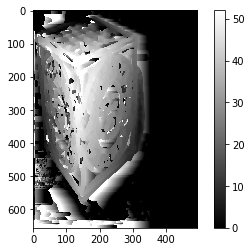

In [152]:
res = np.argmin(D, 2)
ppl.imshow(res,cmap='gray')
ppl.colorbar()

### 4.2 Estimación de la disparidad regularizada

El etiquetado usando exclusivamente términos unitarios
es muy sensible al ruido y propenso a que aparezcan zonas
de píxeles cercanos con mucha variación en las etiquetas.
Esto es especialmente notable en zonas planas (es decir, sin
textura) de las imágenes originales, donde no hay suficiente
información para establecer una correspondencia basándose
exclusivamente en la apariencia visual de ventanas pequeñas. Por eso es necesario incluir un término de suavizado
o regularización en la función de energía. Los tipos de
saltos de etiquetas que aparecerán en el resultado final
dependerán de cómo sea ese término de suavizado.

La función de energía que utilizaremos para calcular
las disparidades en la práctica será el resultado de añadir
a la expresión (6) un término que penalice los cambios de
disparidad en los píxeles vecinos: $$E_r(x) = \sum_{i} D_i(x_i) + \lambda\sum_{ij} \min(k,|x_i-x_j|).$$ Siendo $j$ los índices de los píxeles vecinos del $i$ en la imagen.
La solución al problema de la correspondencia vendrá dado
por el conjunto de etiquetas (disparidades) de los píxeles de
la imagen que minimicen $E_r(x)$.

En [Yuri Boykov, Olga Veksler, and Ramin Zabih. "Fast approximate
energy minimization via graph cuts". *IEEE Transactions on Pattern
Analysis and Machine Intelligence*, 23:1222–1239, 2001.] se presentan métodos para resolver algunos problemas de optimización con varias etiquetas empleando
algoritmos de cortes de grafos. Es recomendable repasar las
secciones 5 y 8.

**Ejercicio 16.** Escribe la función ``find_corresp_aexpansion(D, initLabels, lmb, maxV)``,
que recie un volumen ssd, ``D``, un conjunto inicial de
etiquetas, ``initLabels``, que puede ser el obtenido en el
ejercicio 5, el valor de la constante $\lambda$, y el valor máximo
de la función de coste $|x_i − x_j|$, que tendrás que establecer empíricamente. El resultado de esta función serán las
etiquetas que minimizan $E_r(x)$. Para ello debes utilizar la función ``maxflow.fastmin.aexpansion_grid(D, V, max_cycles=None, labels=None)`` del paquete
*PyMaxFlow*, que resuelve el problema anterior mediante un
algoritmo de cortes de grafos empleando una $\alpha$-expansión.

In [ ]:
def find_corresp_aexpansion(D, initialLabels, lmb, maxV):
        
    labelLenght = D.shape[2]
    V = np.empty([labelLenght, labelLenght])
    
    for i in range(labelLenght):   
        for j in range(labelLenght):
            V[i, j] = min(lmb * np.abs(i - j), maxV)
        
    return maxflow.fastmin.aexpansion_grid(D, V, max_cycles=5, labels=initialLabels)

Llama a esta función y muestra una figura con las etiquetas que resulten de la minimización de la energía para el volumen ssd ``D`` (este proceso puede durar varios minutos).

In [153]:
labels = find_corresp_aexpansion(D, res, 1.5 , 20)

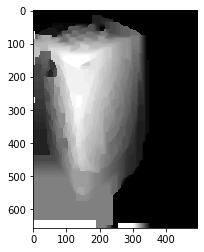

In [154]:
ppl.imshow(labels, cmap='gray')
ppl.show()

# res = np.argmin(D, 2)
# ppl.imshow(res,cmap='gray')
# ppl.colorbar()
# ppl.show()

La matriz de etiquetas óptimas X obtenida de la minimización de la función de energía puede transformarse en
la matriz de disparidades S indexando en cada una de sus
celdas el array de disparidades disps ``S = disps[X]``.
Ahora, el píxel de coordenadas (x, y) de la primera imagen
rectificada tendrá su correspondencia en el píxel de coordenadas (x + S [y, x], y) de la segunda imagen rectificada.

El siguiente ejercicio usa la matriz de disparidades para
establecer automáticamente las correspondencias entre un
par de imágenes sin rectificar.

**Ejercicio 15.** Implementa la función
``plot_correspondences(image1, image2, S, H1,H2)``
que, dado un par de imágenes sin rectificar, la matriz de
disparidades entre las imágenes rectificadas y las homogra-
fías que llevan de las imágenes sin rectificar a las imágenes
rectificadas, pida al usuario puntos en la primera imagen y
dibuje sus correspondencias en la segunda.

In [155]:
def plot_correspondences(image1, image2, S, H1, H2):
    """
    Ask for points in the first image and plot their correspondences in
    the second image.
    
    Parameters
    ----------
    image1, image2 : array_like
        The images (before rectification)
    S : array_like
        The matrix of disparities.
    H1, H2 : array_like
        The homographies which rectify both images.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.c_[np.array(point), 1].T
        ax1.plot(point[0,:], point[1,:], '.r')
        
        # TODO: Determine the correspondence of 'point' in the second image.
        # perhaps you have to swap the image co-ordinates.
        
        rect_point = np.dot(H1, point)
        point_c = rect_point / rect_point[2]
        d = S[int(point_c[1]), int(point_c[0])]
        
        point_c[0] -= d
        point_c = np.dot(npla.inv(H2), point_c)
        point_c = (point_c / point_c[2])[:2]
        
        # TODO: Plot the correspondence with ax2.plot.
        
        ax2.plot(point_c[0], point_c[1] ,'r.')
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

In [158]:
S = disps[labels]
plot_correspondences(img1, img2, S, H1, H2)

154
161
137
137
137


TclError: can't invoke "update" command: application has been destroyed